А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

 

## Описание колонок
- experimentVariant – вариант эксперимента
- version – версия приложения
- purchase – факт покупки

## Задача
Запустите A/A-тест
Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from tqdm.auto import tqdm

In [2]:
hw = pd.read_csv('./hw_aa.csv', sep=';')

In [3]:
hw.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


**Первый запуск А/А теста**

  0%|          | 0/1000 [00:00<?, ?it/s]

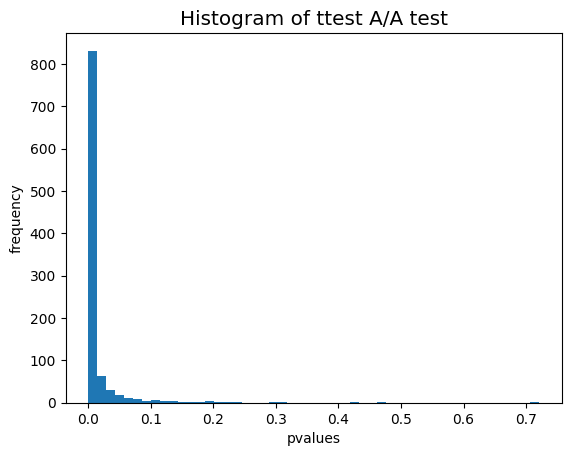

0.937

In [4]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    variant0 = hw[hw.experimentVariant == 0].purchase.sample(n_s, replace=False).values
    variant1 = hw[hw.experimentVariant == 1].purchase.sample(n_s, replace=False).values
    res.append(stats.ttest_ind(variant0, variant1, equal_var=False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A test")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

**Note:**
Доля стат.значимых различий равна 0.943. В 94% случаев мы получаем стат. значимые различия (p-value < 0.05) Это плохо. Ведь по сути различий быть не должно особо.

In [ ]:
hw\
.groupby(['version', 'experimentVariant'])\
.agg({'uid':'nunique'})

In [ ]:
hw\
.groupby(['version', 'experimentVariant'])\
.agg({'purchase':'sum'})

purchase
version  experimentVariant          
v2.8.0   0                        41
         1                      1895
v2.9.0   0                       890
         1                       858
v3.7.4.0 0                       252
         1                       266
v3.8.0.0 0                       328
         1                       384

In [ ]:
hw\
.groupby(['version', 'experimentVariant'])\
.agg({'purchase':'mean'})

purchase
version  experimentVariant          
v2.8.0   0                  0.000993
         1                  0.045606
v2.9.0   0                  0.074658
         1                  0.071304
v3.7.4.0 0                  0.059943
         1                  0.063018
v3.8.0.0 0                  0.057604
         1                  0.062848

А вот и нашлась проблема. В версии v.2.8.0 что-то пошло не так. Средние значение по purchase , не должны сильно отличаться одруг от друга в experimentVariant = 0 и experimentVariant = 1

Попробуем немного изменить тест

  0%|          | 0/1000 [00:00<?, ?it/s]

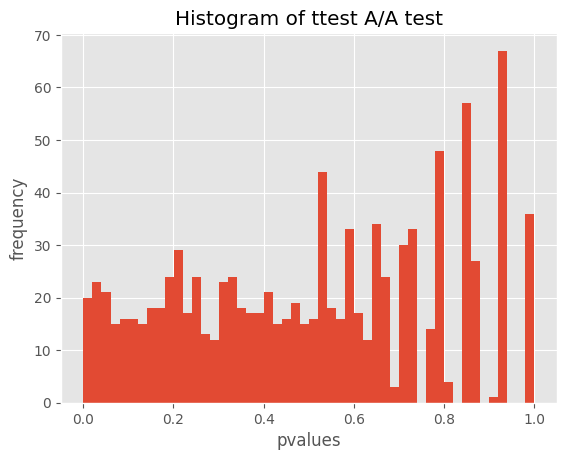

0.052

In [ ]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    variant0 = hw[(hw.experimentVariant == 0) & 
                  (hw.version != 'v2.8.0')].purchase.sample(n_s, replace=False).values
    variant1 = hw[(hw.experimentVariant == 1) & 
                  (hw.version != 'v2.8.0')].purchase.sample(n_s, replace=False).values
    res.append(stats.ttest_ind(variant0, variant1, equal_var=False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A test")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

fpr прблизительно совпал с 5%. Стат. доказано, что различия были на версии v2.8.0